In [1]:
import random
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.evaluation import evaluate_policy
from sb3_contrib.common.maskable.utils import get_action_masks
from sb3_contrib.common.wrappers import ActionMasker
# from sb3_contrib.common.maskable.wrappers import VecActionMasker 
# from sb3_contrib.common.maskable.vec_env import MaskableEnv
# from stable_baselines3.common.vec_env import DummyVecEnv

# 2x2

In [15]:
class TwentyFortyEight2b2Env(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode='human'):
        super().__init__()
        self.render_mode = render_mode
        self.observation_space = spaces.Box(0, 10, shape=(2, 2), dtype=np.int8)
        self.action_space = spaces.Discrete(4)
        self.grid = None

    def reset(self, seed=None, options=None):
        # this lets gymnasium/SB3 seed properly
        super().reset(seed=seed)
        self.grid = np.zeros((2, 2), dtype=np.int8)
        self._add_tile()
        self._add_tile()
        return self.grid.copy(), {"action_mask": self.valid_action_mask()}

    def step(self, action):
        assert self.action_space.contains(action), f"{action} invalid"
        terminated = not self._can_move()
        before = self.grid.copy()
        reward = self._move_and_merge(action)
        if not np.array_equal(before, self.grid):
            self._add_tile()
        else:
            terminated = True
        return self.grid.copy(), reward, terminated, False, {"action_mask": self.valid_action_mask()}

    def render(self):
        grd = (np.where(self.grid != 0, 2**self.grid, np.zeros_like(self.grid))).astype(int)
        f = lambda x: f"{x:>2}" if x != 0 else "  "
        print("-"*7)
        for r in grd:
            print("|", end="")
            print(*map(f, r), end="")
            print("|")
        print("-"*7)
        print("\n")

    def valid_action_mask(self):
        # True = valid, False = would do nothing
        mask = []
        for a in range(self.action_space.n):
            # simulate=True returns reward but *doesn’t* modify self.grid
            moved = self._move_and_merge(a, simulate=True) > 0
            mask.append(moved)
        return np.array(mask, dtype=bool)

    def _add_tile(self):
        empties = list(zip(*np.where(self.grid == 0)))
        if not empties: return
        y, x = random.choice(empties)
        self.grid[y, x] = 1 if random.random() < 0.9 else 2

    def _can_move(self):
        if np.any(self.grid == 0):
            return True
        for a in range(4):
            if self._move_and_merge(a, simulate=True) > 0:
                return True
        return False

    def _move_and_merge(self, action, simulate=False):
        grid = self.grid.copy() if simulate else self.grid
        orig = self.grid.copy()
        total_reward = 0
        for i in range(2):
            line = grid[:, i] if action < 2 else grid[i, :]
            if action % 2 == 1:
                line = line[::-1]
            nonzero = line[line > 0]
            merged, skip = [], False
            for j in range(len(nonzero)):
                if skip:
                    skip = False
                    continue
                if j+1 < len(nonzero) and nonzero[j] == nonzero[j+1]:
                    new_val = nonzero[j] + 1
                    merged.append(new_val)
                    total_reward += 2 ** new_val
                    skip = True
                else:
                    merged.append(nonzero[j])
            merged = np.array(merged + [0]*(2-len(merged)), dtype=np.int8)
            if action % 2 == 1:
                merged = merged[::-1]
            if action < 2:
                grid[:, i] = merged
            else:
                grid[i, :] = merged
        # add in something to really incentivize not doing nothing
        if (grid == orig).all():
            total_reward = -2.0
        if not simulate:
            self.grid = grid
        return total_reward

In [16]:
# class CustomCNN(BaseFeaturesExtractor):
#     """
#     :param observation_space: (gym.Space)
#     :param features_dim: (int) Number of features extracted.
#         This corresponds to the number of unit for the last layer.
#     """

#     def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
#         super(CustomCNN, self).__init__(observation_space, features_dim)
#         # We assume CxHxW images (channels first)
#         # Re-ordering will be done by pre-preprocessing or wrapper
#         n_input_channels =1
#         self.cnn = nn.Sequential(
#             nn.Conv2d(n_input_channels, 10, kernel_size=2, stride=1, padding="same"),
#             nn.ReLU(),
#             nn.Conv2d(10, 10, kernel_size=2, stride=1, padding="same"),
#             nn.ReLU(),
#             nn.Conv2d(10, 10, kernel_size=2, stride=1, padding="same"),
#             nn.ReLU(),
#             nn.Flatten(start_dim=1),
#         )

#         # Compute shape by doing one forward pass
#         with torch.no_grad():
#             n_flatten = self.cnn(
#                 torch.as_tensor(observation_space.sample()[None]).float()
#             ).shape[0]*self.cnn(
#                 torch.as_tensor(observation_space.sample()[None]).float()
#             ).shape[1]
            
#         self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

#     def forward(self, observations) -> torch.Tensor:
#         obs=torch.tensor(observations).float()
#         return self.linear(self.cnn(obs.reshape((obs.shape[0],1,2,2))))

class BlockFeaturesExtractor2D(BaseFeaturesExtractor):
    """
    For a 2D Box obs (shape=(H, W)), takes `blocks` as a list of lists of (r,c) tuples.
    Each block is flattened to a list of flat indices, one Linear per block → 1 output.
    Final features tensor has shape (batch_size, n_blocks).
    """
    def __init__(self,
                 observation_space: gym.spaces.Box,
                 blocks: list[list[tuple[int,int]]],
                 features_dim=0):
        # only support 2D Box for now
        assert isinstance(observation_space, gym.spaces.Box) and len(observation_space.shape) == 2, \
            "Only 2D Box obs supported"
        super().__init__(observation_space, features_dim=len(blocks))

        H, W = observation_space.shape
        flat_size = H * W

        # convert each block of (r,c) pairs to flat indices
        self.block_indices: list[list[int]] = []
        for block in blocks:
            idxs = []
            for (r, c) in block:
                assert 0 <= r < H and 0 <= c < W, f"Index {(r,c)} out of bounds"
                idxs.append(r * W + c)
            self.block_indices.append(idxs)

        # one linear per block
        self.linears = nn.ModuleList([
            nn.Linear(len(idxs), 1)
            for idxs in self.block_indices
        ])

    def forward(self, observations):
        # observations: (batch_size, H, W)
        batch_size = observations.shape[0]
        # flatten spatial dims
        obs_flat = observations.view(batch_size, -1)  # (batch_size, H*W)

        outs = []
        for linear, idxs in zip(self.linears, self.block_indices):
            # gather inputs for this block: (batch_size, block_size)
            xb = obs_flat[:, idxs]
            # project to (batch_size, 1)
            yb = linear(xb)
            outs.append(yb)

        # concatenate to (batch_size, n_blocks)
        return torch.cat(outs, dim=1)


policy_kwargs = dict(
    features_extractor_class=lambda *args, **kwargs: BlockFeaturesExtractor2D(*args, **kwargs, blocks=[
        [
            [0, 0],
            [0, 1]
        ],
        [
            [0, 0],
            [1, 0],
            [1, 1]
        ],
        [
            [1, 1],
            [0, 0]
        ],
        [
            [1, 1],
            [1, 0]
        ],
        [
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
        ]
    ]),
    features_extractor_kwargs=dict(features_dim=4),
)
# 1) sanity-check env
base_env = TwentyFortyEight2b2Env()
check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant
def make_env2b2():
    env = TwentyFortyEight2b2Env(render_mode='human')
    return env

# 2) vectorize
vec_env2b2 = DummyVecEnv([make_env2b2])

# 3) train with any SB3 algo
model2b2 = PPO("MlpPolicy", vec_env2b2, policy_kwargs=policy_kwargs, verbose=1, n_epochs=30, learning_rate=0.001)
# 500_000 with default lr gives a score 300 smth
model2b2.learn(total_timesteps=200_000)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5289 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2361        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.014607476 |
|    clip_fraction        | 0.252       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.000553    |
|    learning_rate        | 0.001       |
|    loss                 | 17.8        |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.0294     |
|    value_loss           | 37          |
-----------------------------------------
-----------------

Threshold 75 -> 0 >=, 1000 <
4.204 2.0 7.010163 50.0 -2.0
Threshold 75 -> 72 >=, 928 <
59.864 62.0 26.258665 170.0 -2.0


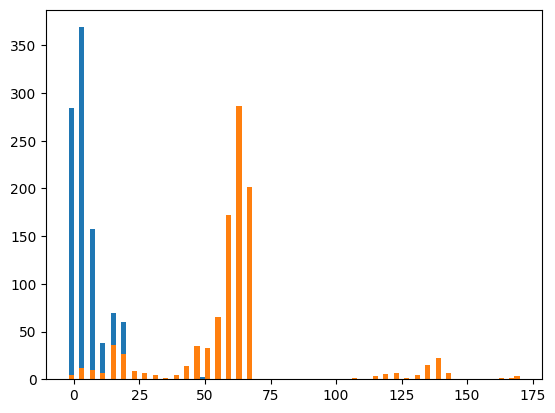

In [18]:
def do_random():
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env2b2.step(action)
        total_reward += reward
    return total_reward
def do_thing():
    obs = vec_env2b2.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model2b2.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env2b2.step(action)
        total_reward += reward
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(1000)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 2))
    thresh = 75
    a = b = 0
    for i in l:
        if i >= thresh:
            a += 1
        else:
            b += 1
    print(f"Threshold {thresh} -> {a} >=, {b} <")
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
do_wfnc(do_random)
do_wfnc(do_thing)

In [42]:
# 4) play one game
obs = vec_env2b2.reset()
done = False
total_reward = 0
k = 0
dirr = {
    0 : "up",
    1 : "down",
    2 : "left",
    3 : "right",
}
vec_env2b2.render()
while not done:
    k += 1
    # am = get_action_masks(env)
    action, _ = model2b2.predict(obs, deterministic=True)
    obs, reward, done, _ = vec_env2b2.step(action)
    total_reward += reward
    print(f"Move {k}: {dirr[action[0]]}, reward: {reward}, total reward: {total_reward}")
    vec_env2b2.render()
    # print(action)
    time.sleep(1)
print("Final score (sum of merges):", total_reward)
vec_env2b2.render()


-------
|    2|
| 4   |
-------


Move 1: up, reward: [0.], total reward: [0.]
-------
| 4  2|
| 4   |
-------


Move 2: down, reward: [8.], total reward: [8.]
-------
|    2|
| 8  2|
-------


Move 3: up, reward: [4.], total reward: [12.]
-------
| 8  4|
| 2   |
-------


Move 4: right, reward: [0.], total reward: [12.]
-------
| 8  4|
| 2  2|
-------


Move 5: right, reward: [4.], total reward: [16.]
-------
| 8  4|
| 2  4|
-------


Move 6: up, reward: [8.], total reward: [24.]
-------
| 8  8|
| 2  2|
-------


Move 7: left, reward: [20.], total reward: [44.]
-------
|16   |
| 4  2|
-------


Move 8: up, reward: [0.], total reward: [44.]
-------
|16  2|
| 4  2|
-------


Move 9: down, reward: [4.], total reward: [48.]
-------
|16  2|
| 4  4|
-------


Move 10: left, reward: [8.], total reward: [56.]
-------
|16  2|
| 8  2|
-------


Move 11: up, reward: [4.], total reward: [60.]
-------
|16  4|
| 8  2|
-------


Move 12: up, reward: [-2.], total reward: [58.]
-------
|     |
| 4  2|

In [45]:
envv = DummyVecEnv([lambda *args: TwentyFortyEight2b2Env(render_mode='human')])
envv.envs[0].grid = np.array([[1, 2], [1, 3]], dtype=int)

In [46]:
envv.envs[0]._move_and_merge(1)
envv.render()

AH [np.int64(2)]
AH [np.int64(3), np.int64(2)]
-------
|    4|
| 4  8|
-------




In [ ]:
vec_env2b2.envs[0]._move_and_merge()

True

# 4x4

In [2]:
class TwentyFortyEightEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 4}

    def __init__(self, render_mode='human'):
        super().__init__()
        self.render_mode = render_mode
        self.observation_space = spaces.Box(0, 17, shape=(4, 4), dtype=np.int32)
        self.action_space = spaces.Discrete(4)
        self.grid = None

    def reset(self, seed=None, options=None):
        # this lets gymnasium/SB3 seed properly
        super().reset(seed=seed)
        self.grid = np.zeros((4, 4), dtype=np.int32)
        self._add_tile()
        self._add_tile()
        return self.grid.copy(), {"action_mask": self.valid_action_mask()}

    def step(self, action):
        assert self.action_space.contains(action), f"{action} invalid"
        before = self.grid.copy()
        reward = self._move_and_merge(action)
        terminated = not self._can_move()
        if not np.array_equal(before, self.grid):
            self._add_tile()
        return self.grid.copy(), reward, terminated, False, {"action_mask": self.valid_action_mask()}

    def render(self):
        grd = (np.where(self.grid != 0, 2**self.grid.astype(np.int32), np.zeros_like(self.grid))).astype(int)
        f = lambda x: f"{x:>3}" if x != 0 else "   "
        print("-"*17)
        for r in grd:
            print("|", end="")
            print(*map(f, r), end="")
            print("|")
        print("-"*17)
        print("\n")

    def valid_action_mask(self):
        # True = valid, False = would do nothing
        mask = []
        for a in range(self.action_space.n):
            # simulate=True returns reward but *doesn’t* modify self.grid
            moved = self._move_and_merge(a, simulate=True) > 0
            mask.append(moved)
        return np.array(mask, dtype=bool)

    def _add_tile(self):
        empties = list(zip(*np.where(self.grid == 0)))
        if not empties: return
        y, x = random.choice(empties)
        self.grid[y, x] = 1 if random.random() < 0.9 else 2

    def _can_move(self):
        if np.any(self.grid == 0):
            return True
        for a in range(4):
            if self._move_and_merge(a, simulate=True) > 0:
                return True
        return False

    def _move_and_merge(self, action, simulate=False):
        grid = self.grid.copy() if simulate else self.grid
        orig = self.grid.copy()
        total_reward = 0
        for i in range(4):
            line = grid[:, i] if action < 2 else grid[i, :]
            if action % 2 == 1:
                line = line[::-1]
            nonzero = line[line > 0]
            merged, skip = [], False
            for j in range(len(nonzero)):
                if skip:
                    skip = False
                    continue
                if j+1 < len(nonzero) and nonzero[j] == nonzero[j+1]:
                    new_val = nonzero[j] + 1
                    merged.append(new_val)
                    total_reward += 2**new_val
                    skip = True
                else:
                    merged.append(nonzero[j])
            merged = np.array(merged + [0]*(4-len(merged)), dtype=np.int32)
            if action % 2 == 1:
                merged = merged[::-1]
            if action < 2:
                grid[:, i] = merged
            else:
                grid[i, :] = merged
        # add in something to really incentivize not doing nothing
        if (grid == orig).all():
            total_reward = -2.0
        if not simulate:
            self.grid = grid
        return total_reward

In [4]:
# # 1) sanity-check env
# base_env = TwentyFortyEightEnv()
# check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

# def make_env():
#     env = TwentyFortyEightEnv(render_mode='human')
#     return ActionMasker(env, lambda e: e.valid_action_mask())

# class MaskableDummyVecEnv(DummyVecEnv):
#     def has_attr(self, name: str) -> bool:
#         # MaskablePPO will call `env.has_attr("action_masks")`
#         return all(hasattr(env, name) for env in self.envs)
#     def action_masks(self) -> np.ndarray:
#         # must return shape (n_envs, n_actions)
#         masks = [env.action_masks() for env in self.envs]
#         return np.stack(masks, axis=0)

# # 2) vectorize
# vec_env = MaskableDummyVecEnv([make_env])


# # 3) train with any SB3 algo
# model = MaskablePPO("MlpPolicy", vec_env, verbose=1, n_epochs=30, learning_rate=5e-3)
# # 500_000 with default lr gives a score 300 smth
# model.learn(total_timesteps=100_000)


In [3]:

import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from stable_baselines3 import PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 160):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        self.dep =30

        self.embed= nn.Embedding(20,self.dep)
        self.posEm= nn.Embedding(16,self.dep)
        self.cnn1 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep,4,4]) )

        self.cnn2 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep,4,4]) )
        self.cnn3 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep, self.dep, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep,4,4]))

        self.cnn4 = nn.Sequential(

            nn.Conv2d(self.dep, self.dep//4*3, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep//4*3, self.dep//2, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.Conv2d(self.dep//2, self.dep//4, kernel_size=3, stride=1, padding="same"),
            nn.ReLU(),
            nn.LayerNorm([self.dep//4,4,4]),
            nn.Flatten(start_dim=1))

        n_flatten = self.dep//4*16

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 32*2), nn.ReLU(),
            # nn.Linear(50, 50), nn.ReLU(),
            nn.Linear(32*2, features_dim), nn.ReLU(),
            )
        self.to(device=device)
    def do_cnn(self, input_1):
        res=self.cnn1(input_1)+input_1
        res=self.cnn2(res)+res
        return self.cnn4(self.cnn3(res)+res)

    def do_embed(self, observations):
        observations=observations.to(device=device)
        add_pos=self.posEm(torch.tensor([i for i in range(16)], dtype=torch.int,device=device)).reshape((4,4,self.dep))
        obs=observations.type(torch.int)
        return(self.embed(obs)+add_pos).reshape((observations.shape[0],self.dep,4,4))


    def forward(self, observations) -> torch.Tensor:
        embed= self.do_embed(observations)
        final1=self.linear(self.do_cnn(embed))
        # final2= self.linear(self.cnn( torch.rot90( embed,1,[2,3])))
        # final3= self.linear(self.cnn( torch.rot90( embed,2,[2,3])))
        # final4= self.linear(self.cnn( torch.rot90( embed,3,[2,3])))

        # print(torch.concat( (final1,final2,final3,final4)).shape,"Hi",final1.shape)
        # return torch.concat( (final1,final2,final3,final4),dim=1)
        return final1

# 1) sanity-check env

# 2) vectorize

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=64),
    net_arch=[64, 64]
)

base_env = TwentyFortyEightEnv()
check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

def make_env():
    env = TwentyFortyEightEnv(render_mode='human')
    return env

vec_env = DummyVecEnv([make_env])
model = PPO("MlpPolicy", vec_env, policy_kwargs=policy_kwargs, verbose=1, n_epochs=100, batch_size=256)

model.learn(100000)

/Users/thomasdellavigna/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 628  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------


KeyboardInterrupt: 

In [113]:
# 1) sanity-check env
base_env = TwentyFortyEightEnv()
check_env(base_env, warn=True)                # <-- will raise if your env is non-compliant

def make_env():
    env = TwentyFortyEightEnv(render_mode='human')
    return env
def make_env_play():
    env = TwentyFortyEightEnv_play(render_mode='human')
    return env
# 2) vectorize
# vec_env = DummyVecEnv([make_env])

vec_env_play = DummyVecEnv([make_env_play])

/Users/thomasdellavigna/Library/Python/3.9/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


In [ ]:
#rtain
model = PPO("MlpLstmPolicy", vec_env, verbose=1, n_epochs=30, learning_rate=5e-3)
# 500_000 with default lr gives a score 300 smth
model.learn(total_timesteps=200_000)

/Users/aayanarish/Library/Python/3.10/lib/python/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


ValueError: Policy MlpLstmPolicy unknown

In [132]:
# 4) play one game
obs = vec_env.reset()
done = False
total_reward = 0
k = 0
dirr = {
    0 : "up",
    1 : "down",
    2 : "left",
    3 : "right",
}
env = make_env()
# vec_env_play = make_env_play()
re=nn.ReLU()
while not done:
    k += 1
    # am = get_action_masks(env)
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, _ = vec_env.step(action)
    reward=max(int(reward[0]),0)
    total_reward += reward
    print(f"Move {k}: {dirr[action[0]]}, reward: {reward}, total reward: {total_reward}")
    vec_env.render()
    # print(action)
    time.sleep(0.2)
print("Final score (sum of merges):", total_reward)

/var/folders/zy/tjrmvbjx24dcxfzdxg41rr400000gp/T/ipykernel_77553/2153850915.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs=torch.tensor(observations, dtype=int)


Move 1: left, reward: 4, total reward: 4
-----------------
|          2    |
|               |
|  4            |
|               |
-----------------


Move 2: down, reward: 0, total reward: 4
-----------------
|               |
|          2    |
|               |
|  4       2    |
-----------------


Move 3: down, reward: 4, total reward: 8
-----------------
|               |
|               |
|  2            |
|  4       4    |
-----------------


Move 4: left, reward: 8, total reward: 16
-----------------
|  2            |
|               |
|  2            |
|  8            |
-----------------


Move 5: left, reward: 0, total reward: 16
-----------------
|  2            |
|               |
|  2            |
|  8            |
-----------------


Move 6: left, reward: 0, total reward: 16
-----------------
|  2            |
|               |
|  2            |
|  8            |
-----------------


Move 7: right, reward: 0, total reward: 16
-----------------
|              2|
|      4    

1033.5 1044.0 482.36807 2532.0 256.0


/var/folders/zy/tjrmvbjx24dcxfzdxg41rr400000gp/T/ipykernel_77553/2153850915.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs=torch.tensor(observations, dtype=int)


1160.0 1126.0 529.5431993709295 2856.0 316.0


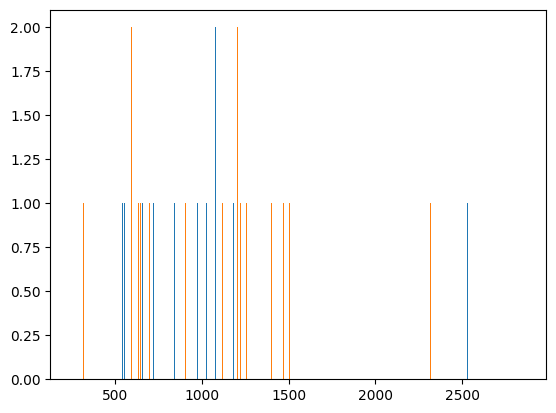

In [ ]:
def do_random():
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_thing():
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(40)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 2))
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
do_wfnc(do_random)
do_wfnc(do_thing)

1178.6 1072.0 570.0718200367389 3168.0 228.0


/var/folders/zy/tjrmvbjx24dcxfzdxg41rr400000gp/T/ipykernel_77553/2153850915.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs=torch.tensor(observations, dtype=int)


1138.32 1072.0 577.67566817376 3092.0 244.0


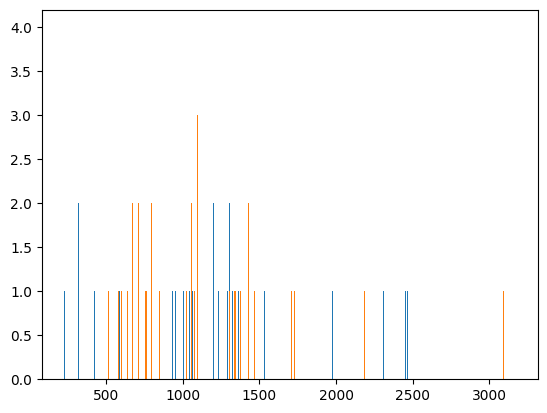

In [133]:
def do_random():
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action = [random.randint(0, 3)]
        _, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_thing():
    obs = vec_env.reset()
    done = False
    total_reward = 0
    k = 0
    while not done:
        k += 1
        # am = get_action_masks(env)
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, done, _ = vec_env.step(action)
        total_reward += max(reward[0],0)
    return total_reward
def do_wfnc(fnc):
    l = np.array([fnc() for _ in range(100)])
    plt.hist(l, bins=range(int(np.min(l)), int(np.max(l))+1, 2))
    print(np.mean(l), np.median(l), np.std(l), np.max(l), np.min(l))
do_wfnc(do_random)
do_wfnc(do_thing)